First we have to download and install the pip package

In [1]:
!pip3 install -U ncps pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.2/812.2 KB 641.7 kB/s eta 0:00:0000:0100:01
  Using cached PyYAML-6.0.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (705 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 KB 785.5 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 KB 768.4 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 1.0 MB/s eta 0:00:00a 0:00:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.6/301.6 KB 1.4 MB/s eta 0:00:0000:0100:01
  Using cached attrs-23.2.0-py3-none-any.whl (60 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.5/239.5 KB 1.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.3/124.3 KB 1.6 MB/s eta 0:00:00a 0:00:01


In [1]:
import numpy as np
import torch.nn as nn
from ncps.wirings import AutoNCP
from ncps.torch import LTC
import pytorch_lightning as pl
import torch
import torch.utils.data as data

For the training we will use Pytorch-Lightning, thus we have to define our learner module.

In [2]:
# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)


Next we define some toy dataset and create the corresponding DataLoaders

data_x.size:  torch.Size([1, 48, 2])
data_y.size:  torch.Size([1, 48, 1])


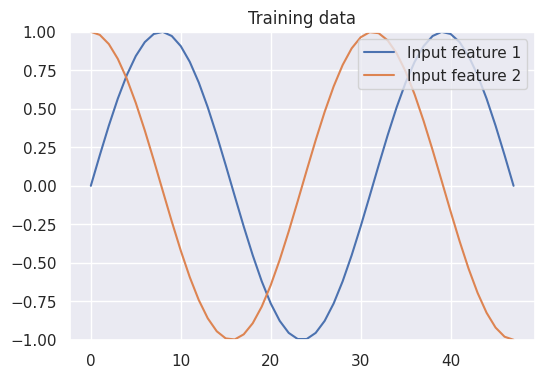

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

in_features = 2
out_features = 1
N = 48  # Length of the time-series
# Input feature is a sine and a cosine wave
data_x = np.stack(
    [np.sin(np.linspace(0, 3 * np.pi, N)), np.cos(np.linspace(0, 3 * np.pi, N))], axis=1
)
data_x = np.expand_dims(data_x, axis=0).astype(np.float32)  # Add batch dimension
# Target output is a sine with double the frequency of the input signal
data_y = np.sin(np.linspace(0, 6 * np.pi, N)).reshape([1, N, 1]).astype(np.float32)
data_x = torch.Tensor(data_x)
data_y = torch.Tensor(data_y)
print("data_x.size: ", str(data_x.size()))
print("data_y.size: ", str(data_y.size()))
dataloader = data.DataLoader(
    data.TensorDataset(data_x, data_y), batch_size=1, shuffle=True, num_workers=4
)
# Let's visualize the training data
sns.set()
plt.figure(figsize=(6, 4))
plt.plot(data_x[0, :, 0], label="Input feature 1")
plt.plot(data_x[0, :, 1], label="Input feature 2")

plt.ylim((-1, 1))
plt.title("Training data")
plt.legend(loc="upper right")
plt.show()

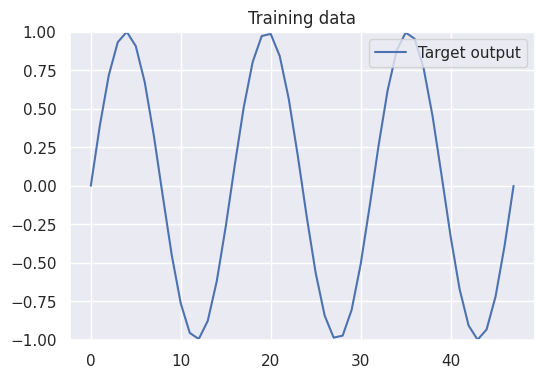

In [4]:
sns.set()
plt.figure(figsize=(6, 4))
plt.plot(data_y[0, :, 0], label="Target output")
plt.ylim((-1, 1))
plt.title("Training data")
plt.legend(loc="upper right")
plt.show()

Here we can finally create a LTCCell and make use of the predefined sparse wiring structures of the keras-ncp package. For simplicity we will just define a fully-connected RNN

In [5]:
wiring = AutoNCP(16, out_features)  # 16 units, 1 motor neuron

ltc_model = LTC(in_features, wiring, batch_first=True)
learn = SequenceLearner(ltc_model, lr=0.01)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=400,
    gradient_clip_val=1,  # Clip gradient to stabilize training
    accelerator="cpu"
)

GPU available: True (cuda), used: False


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/mnt/nvme0n1/khubaib_mubashir/ncps/ncpsvenv/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


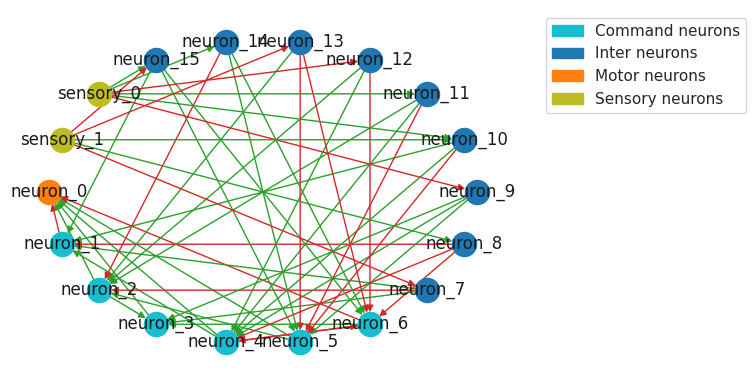

In [16]:
sns.set_style("white")
plt.figure(figsize=(8, 4))
legend_handles = wiring.draw_graph(draw_labels=True,  neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1.25, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

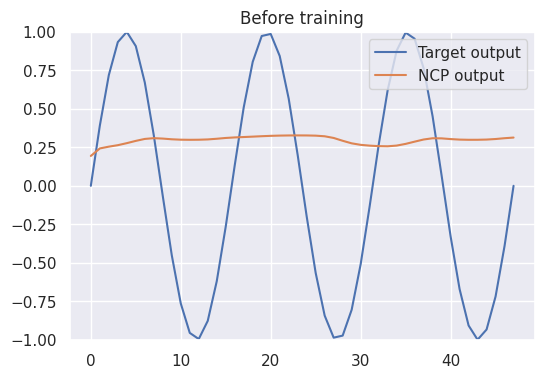

In [12]:
sns.set()
with torch.no_grad():
  prediction = ltc_model(data_x)[0].numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="NCP output")
plt.ylim((-1, 1))
plt.title("Before training")
plt.legend(loc="upper right")
plt.show()

... and train our network

In [13]:
trainer.fit(learn, dataloader)

/mnt/nvme0n1/khubaib_mubashir/ncps/ncpsvenv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
Missing logger folder: log/lightning_logs

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | LTC  | 1.5 K  | train
---------------------------------------
1.2 K     Trainable params
288       Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
/mnt/nvme0n1/khubaib_mubashir/ncps/ncpsvenv/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, v_num=0, train_loss=0.000245]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=0, train_loss=0.000245]


In [14]:
results = trainer.test(learn, dataloader)

/mnt/nvme0n1/khubaib_mubashir/ncps/ncpsvenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.77it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │  0.00024448809563182294   │
└───────────────────────────┴───────────────────────────┘

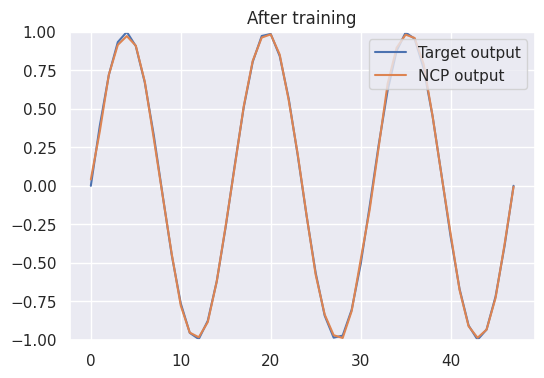

In [15]:
sns.set()
with torch.no_grad():
  prediction = ltc_model(data_x)[0].numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="NCP output")
plt.ylim((-1, 1))
plt.title("After training")
plt.legend(loc="upper right")
plt.show()

In [23]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision.transforms as transforms
import pytorch_lightning as pl
from torchvision.datasets import MNIST
from ncps.wirings import AutoNCP
from ncps.torch import LTC
import matplotlib.pyplot as plt
import seaborn as sns

# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

# Load MNIST data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

val_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
val_loader = data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

# Define the model
in_features = 28  # MNIST images are 28x28 pixels
out_features = 10  # There are 10 classes in MNIST
wiring = AutoNCP(16, out_features)  # 16 units, 1 motor neuron

ltc_model = LTC(in_features, wiring, batch_first=True)
learn = SequenceLearner(ltc_model, lr=0.01)

# Train the model
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=10,
    gradient_clip_val=1,  # Clip gradient to stabilize training
    accelerator="cpu"
)

trainer.fit(learn, train_loader, val_loader)

# Test the model
results = trainer.test(learn, val_loader)

sns.set()
test_dataset = iter(val_loader).next()
data_x, data_y = test_dataset

with torch.no_grad():
    prediction = ltc_model(data_x)[0].numpy()

plt.figure(figsize=(6, 4))
plt.plot(data_y.numpy(), label="Target output")
plt.plot(prediction[:, 0], label="NCP output")
plt.ylim((0, 10))
plt.title("After training")
plt.legend(loc="upper right")
plt.show()


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [22:22<00:00, 7386.22it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 35275.20it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [02:06<00:00, 13019.93it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7245.56it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/mnt/nvme0n1/khubaib_mubashir/ncps/ncpsvenv/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | LTC  | 3.6 K  | train
---------------------------------------
2.9 K     Trainable params
704       Non-trainable params
3.6 K     Total params
0.015     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: The size of tensor a (16) must match the size of tensor b (28) at non-singleton dimension 2

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision.transforms as transforms
import pytorch_lightning as pl
from torchvision.datasets import MNIST
from ncps.wirings import AutoNCP
from ncps.torch import LTC
import matplotlib.pyplot as plt
import seaborn as sns

# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1, 1)  # Flatten and add time dimension
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view(x.size(0), -1)  # Flatten output
        loss = nn.CrossEntropyLoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1, 1)  # Flatten and add time dimension
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view(x.size(0), -1)  # Flatten output
        loss = nn.CrossEntropyLoss()(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

# Load MNIST data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

val_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
val_loader = data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

# Define the model
in_features = 784  # MNIST images flattened
out_features = 10  # There are 10 classes in MNIST
wiring = AutoNCP(16, out_features)  # 16 units, 1 motor neuron

ltc_model = LTC(in_features, wiring, batch_first=True)
learn = SequenceLearner(ltc_model, lr=0.01)

# Train the model
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=10,
    gradient_clip_val=1,  # Clip gradient to stabilize training
    # accelerator="cpu"
)

trainer.fit(learn, train_loader, val_loader)

# Test the model
results = trainer.test(learn, val_loader)

# # Visualize predictions
# sns.set()
# test_dataset = iter(val_loader).next()
# data_x, data_y = test_dataset
# data_x = data_x.view(data_x.size(0), -1, 1)  # Flatten and add time dimension

# with torch.no_grad():
#     prediction = ltc_model(data_x)[0].numpy()

# plt.figure(figsize=(6, 4))
# plt.plot(data_y.numpy(), label="Target output")
# plt.plot(prediction[:, 0], label="NCP output")
# plt.ylim((0, 10))
# plt.title("After training")
# plt.legend(loc="upper right")
# plt.show()


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | LTC  | 65.6 K | train
---------------------------------------
52.8 K    Trainable params
12.8 K    Non-trainabl

Epoch 9: 100%|██████████| 938/938 [55:07<00:00,  0.28it/s, v_num=3, train_loss=2.280, val_loss=2.300]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 938/938 [55:07<00:00,  0.28it/s, v_num=3, train_loss=2.280, val_loss=2.300]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████| 157/157 [02:07<00:00,  1.23it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    2.3044848442077637     │
└───────────────────────────┴───────────────────────────┘

AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute 'next'

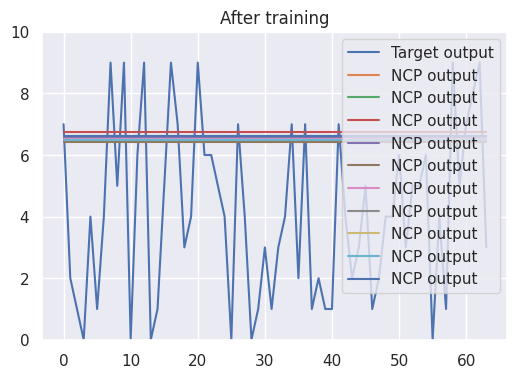

In [2]:
sns.set()
test_dataset = next(iter(val_loader))  # Corrected method to get the next item
data_x, data_y = test_dataset
data_x = data_x.view(data_x.size(0), -1, 1)  # Flatten and add time dimension

with torch.no_grad():
    prediction = ltc_model(data_x)[0].numpy()

plt.figure(figsize=(6, 4))
plt.plot(data_y.numpy(), label="Target output")
plt.plot(prediction[:, 0], label="NCP output")
plt.ylim((0, 10))
plt.title("After training")
plt.legend(loc="upper right")
plt.show()

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/mnt/nvme0n1/khubaib_mubashir/ncps/ncpsvenv/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name  | Type | Params | Mode
--------------------------------------
0 | model | LTC  | 65.6 K | eval
--------------------------------------
52.8 K    Trainable params
12.8 K    Non-trainable params
65.6 K    Total params
0.263     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 938/938 [1:15:30<00:00,  0.21it/s, v_num=5, train_loss=2.310, val_loss=2.310]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing DataLoader 0: 100%|██████████| 157/157 [02:44<00:00,  0.95it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    2.3064382076263428     │
└───────────────────────────┴───────────────────────────┘

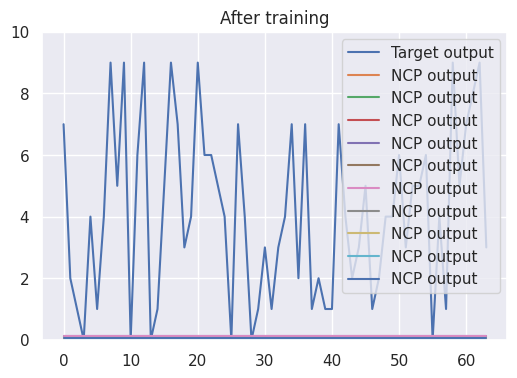

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision.transforms as transforms
import pytorch_lightning as pl
from torchvision.datasets import MNIST
from ncps.wirings import AutoNCP
from ncps.torch import LTC
import matplotlib.pyplot as plt
import seaborn as sns

# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1, 1)  # Flatten and add time dimension
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view(x.size(0), -1)  # Flatten output
        loss = nn.CrossEntropyLoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1, 1)  # Flatten and add time dimension
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view(x.size(0), -1)  # Flatten output
        loss = nn.CrossEntropyLoss()(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

# Load MNIST data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

val_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
val_loader = data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

# Define the model
in_features = 784  # MNIST images flattened
out_features = 10  # There are 10 classes in MNIST
wiring = AutoNCP(16, out_features)  # 16 units, 1 motor neuron

ltc_model_cpu = LTC(in_features, wiring, batch_first=True)
learn_cpu = SequenceLearner(ltc_model, lr=0.01)

# Train the model
trainer_cpu = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=10,
    gradient_clip_val=1,  # Clip gradient to stabilize training
    accelerator="cpu"
)

trainer_cpu.fit(learn_cpu, train_loader, val_loader)

# Test the model
results_cpu = trainer_cpu.test(learn_cpu, val_loader)

# Visualize predictions
sns.set()
test_dataset = next(iter(val_loader))  # Corrected method to get the next item
data_x, data_y = test_dataset
data_x = data_x.view(data_x.size(0), -1, 1)  # Flatten and add time dimension

with torch.no_grad():
    prediction_cpu = ltc_model_cpu(data_x)[0].numpy()

plt.figure(figsize=(6, 4))
plt.plot(data_y.numpy(), label="Target output")
plt.plot(prediction_cpu[:, 0], label="NCP output")
plt.ylim((0, 10))
plt.title("After training")
plt.legend(loc="upper right")
plt.show()


In [5]:
pip install av

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 5.2 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import random
import torch
import torch.nn as nn

from torchvision.io import read_video
from torchvision import transforms
import torch.utils.data as data
import pytorch_lightning as pl
from ncps.wirings import AutoNCP
from ncps.torch import LTC

# Dataset class for UCF101
class UCF101Dataset(data.Dataset):
    def __init__(self, video_files, transform=None):
        self.video_files = video_files
        self.transform = transform

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_path = self.video_files[idx]
        video, _, _ = read_video(video_path)
        video = video.permute(0, 3, 1, 2)  # Change to (T, C, H, W)

        if self.transform:
            video = [self.transform(frame) for frame in video]
            video = torch.stack(video)

        return video

def setup_datasets(root_dir, split_ratio=0.8, transform=None):
    # List all video files
    video_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root_dir) for f in filenames if f.endswith('.avi')]
    random.shuffle(video_files)  # Shuffle to randomize the training and testing sets

    # Split data
    split_point = int(len(video_files) * split_ratio)
    train_files = video_files[:split_point]
    test_files = video_files[split_point:]

    # Create datasets
    train_dataset = UCF101Dataset(train_files, transform=transform)
    test_dataset = UCF101Dataset(test_files, transform=transform)

    return train_dataset, test_dataset

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor and scale to [0, 1]
    transforms.Resize((32, 32)),  # Reduce resolution
    transforms.Grayscale(),  # Convert to grayscale
    transforms.Normalize(mean=[0.485], std=[0.229])  # Normalize (single channel)
])
# Setup datasets
root_dir = '/mnt/nvme0n1/khubaib_mubashir/ncps/UCF-101'
train_dataset, test_dataset = setup_datasets(root_dir, transform=transform)
train_loader = data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
test_loader = data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

# Model definition
class VideoSequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        # Flatten spatial dimensions to fit into the NCP model
        x = x.view(x.size(0), x.size(1), -1)
        y_hat, _ = self.model(x)
        return y_hat

    def training_step(self, batch, batch_idx):
        x, y = batch  # Expecting that data loader now also provides labels
        y_hat = self.forward(x)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss_fn(y_hat, y)
        self.log('val_loss', loss)
        return {'val_loss': loss}

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss_fn(y_hat, y)
        self.log('test_loss', loss)
        return {'test_loss': loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

# Define the wiring and the LTC model for classification
in_features = 32*32*1  # Assuming frames are resized to 64x64 and RGB
out_features = 101  # Corresponding to 101 classes in UCF101
wiring = AutoNCP(144, out_features)  # Adjust neurons as necessary for complexity
ltc_model = LTC(in_features, wiring, batch_first=True)

# Initialize the learner with the LTC model
learner = VideoSequenceLearner(ltc_model)

# Trainer
trainer = pl.Trainer(max_epochs=10, accelerator='gpu', devices=1 if torch.cuda.is_available() else 0)
trainer.fit(learner, train_loader)
trainer.test(learner, test_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/mnt/nvme0n1/khubaib_mubashir/ncps/ncpsvenv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2024-07-01 05:54:32.983526: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

Epoch 0:   0%|          | 0/7050 [00:00<?, ?it/s] 

/mnt/nvme0n1/khubaib_mubashir/ncps/ncpsvenv/lib/python3.10/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")
/mnt/nvme0n1/khubaib_mubashir/ncps/ncpsvenv/lib/python3.10/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")
/mnt/nvme0n1/khubaib_mubashir/ncps/ncpsvenv/lib/python3.10/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")
/mnt/nvme0n1/khubaib_mubashir/ncps/ncpsvenv/lib/python3.10/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.war

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/mnt/nvme0n1/khubaib_mubashir/ncps/ncpsvenv/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/mnt/nvme0n1/khubaib_mubashir/ncps/ncpsvenv/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/mnt/nvme0n1/khubaib_mubashir/ncps/ncpsvenv/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_44204/3883442403.py", line 28, in __getitem__
    video = [self.transform(frame) for frame in video]
  File "/tmp/ipykernel_44204/3883442403.py", line 28, in <listcomp>
    video = [self.transform(frame) for frame in video]
  File "/mnt/nvme0n1/khubaib_mubashir/ncps/ncpsvenv/lib/python3.10/site-packages/torchvision/transforms/transforms.py", line 95, in __call__
    img = t(img)
  File "/mnt/nvme0n1/khubaib_mubashir/ncps/ncpsvenv/lib/python3.10/site-packages/torchvision/transforms/transforms.py", line 137, in __call__
    return F.to_tensor(pic)
  File "/mnt/nvme0n1/khubaib_mubashir/ncps/ncpsvenv/lib/python3.10/site-packages/torchvision/transforms/functional.py", line 142, in to_tensor
    raise TypeError(f"pic should be PIL Image or ndarray. Got {type(pic)}")
TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>


In [ ]:
import os
import random
import torch
from torchvision.io import read_video
from torchvision import transforms
import torch.utils.data as data
import pytorch_lightning as pl
from ncps.wirings import AutoNCP
from ncps.torch import LTC

# Dataset class for UCF101
class UCF101Dataset(data.Dataset):
    def __init__(self, video_files, transform=None):
        self.video_files = video_files
        self.transform = transform

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_path = self.video_files[idx]
        video, _, _ = read_video(video_path)
        video = video.permute(0, 3, 1, 2)  # Change to (T, C, H, W)

        if self.transform:
            video = [self.transform(frame) for frame in video]
            video = torch.stack(video)

        return video

def setup_datasets(root_dir, split_ratio=0.8, transform=None):
    # List all video files
    video_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root_dir) for f in filenames if f.endswith('.avi')]
    random.shuffle(video_files)  # Shuffle to randomize the training and testing sets

    # Split data
    split_point = int(len(video_files) * split_ratio)
    train_files = video_files[:split_point]
    test_files = video_files[split_point:]

    # Create datasets
    train_dataset = UCF101Dataset(train_files, transform=transform)
    test_dataset = UCF101Dataset(test_files, transform=transform)

    return train_dataset, test_dataset

# Define transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to consistent dimensions
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize like ImageNet
])

# Setup datasets
root_dir = '/mnt/nvme0n1/khubaib_mubashir/ncps/UCF-101'
train_dataset, test_dataset = setup_datasets(root_dir, transform=transform)
train_loader = data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
test_loader = data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

# Model definition
class VideoSequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        # Flatten spatial dimensions to fit into the NCP model
        x = x.view(x.size(0), x.size(1), -1)
        y_hat, _ = self.model(x)
        return y_hat

    def training_step(self, batch, batch_idx):
        x, y = batch  # Expecting that data loader now also provides labels
        y_hat = self.forward(x)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss_fn(y_hat, y)
        self.log('val_loss', loss)
        return {'val_loss': loss}

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss_fn(y_hat, y)
        self.log('test_loss', loss)
        return {'test_loss': loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

# Define the wiring and the LTC model for classification
in_features = 64 * 64 * 3  # Assuming frames are resized to 64x64 and RGB
out_features = 101  # Corresponding to 101 classes in UCF101
wiring = AutoNCP(16, out_features)  # Adjust neurons as necessary for complexity
ltc_model = LTC(in_features, wiring, batch_first=True)

# Initialize the learner with the LTC model
learner = VideoSequenceLearner(ltc_model)

# Trainer
trainer = pl.Trainer(max_epochs=10, gpus=1 if torch.cuda.is_available() else 0)
trainer.fit(learner, train_loader)
trainer.test(learner, test_loader)
